In [1]:
%matplotlib inline
import utils; reload(utils)
from utils import *
from utils import *
from vgg16 import Vgg16

Using Theano backend.


In [2]:
batch_size = 32

In [3]:
path = os.path.abspath(os.path.abspath('.') + "/../data/statefarm/sample/")
# path = os.path.abspath(os.path.abspath('.') + "/../data/statefarm/")
path

'/home/taot/github/fastai-courses/homework/data/statefarm/sample'

# Data Preparation

In [ ]:
%pwd

In [ ]:
%cd ../data/statefarm

In [ ]:
%cd train

#### Create Validation Data

In [ ]:
import shutil

In [ ]:
os.mkdir('./valid')

In [ ]:
for d in glob('c?'):
    os.mkdir('../valid/' + d)

In [ ]:
for d1 in glob('c?'):
    g = glob(d1 + '/*.jpg')
    shuf = np.random.permutation(g)
    for i in range(200):
        shutil.move(shuf[i], '../valid/' + shuf[i])

#### Create Sample Data

In [ ]:
%pwd

In [ ]:
%mkdir sample
%mkdir sample/train
%mkdir sample/valid

In [ ]:
%cd train

In [ ]:
for d in glob('c*'):
    os.mkdir('../sample/train/'+d)
    os.mkdir('../sample/valid/'+d)

In [ ]:
g = glob('c?/*.jpg')
shuf = np.random.permutation(g)
for i in range(2500):
    shutil.copyfile(shuf[i], '../sample/train/' + shuf[i])

In [ ]:
%cd ../valid

In [ ]:
g = glob('c?/*.jpg')
shuf = np.random.permutation(g)
for i in range(1000):
    shutil.copyfile(shuf[i], '../sample/valid/' + shuf[i])

In [ ]:
%pwd

In [ ]:
%cd ../test/unknown

In [ ]:
%mkdir -p ../../sample/test/unknown

In [ ]:
g = glob('*.jpg')
shuf = np.random.permutation(g)
for i in range(2000):
    shutil.copyfile(shuf[i], '../../sample/test/unknown/' + shuf[i])

# Create Batches

In [4]:
batches = get_batches(path + '/train', batch_size=batch_size)
val_batches = get_batches(path + '/valid', batch_size=batch_size)

Found 2500 images belonging to 10 classes.
Found 1000 images belonging to 10 classes.


# Basic Model

In [ ]:
model = Sequential([
    BatchNormalization(axis=1, input_shape=(3, 224, 224)),
    Flatten(),
    Dense(10, activation='softmax')
])

In [ ]:
model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit_generator(batches, batches.nb_sample, 1,
    validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

In [ ]:
model.summary()

In [ ]:
10 * 3 * 224 * 224

In [ ]:
l = model.layers
l

In [ ]:
pred = model.predict_generator(batches, batches.N)

In [ ]:
# perhaps learning rate too high, so the network jumps to a solution where it predicts one
# or two classes with high confidence
np.round(pred[500:550], 2)

In [ ]:
# Now lower the learning rate
model = Sequential([
    BatchNormalization(axis=1, input_shape=(3, 224, 224)),
    Flatten(),
    Dense(10, activation='softmax')
])
model.compile(Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model.fit_generator(batches, batches.nb_sample, 1,
    validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

In [ ]:
test_batches = get_batches(path + '/test', batch_size=batch_size, shuffle=False)

In [ ]:
pred = model.predict_generator(test_batches, test_batches.nb_sample)

In [ ]:
test_filenames = test_batches.filenames[:10]
test_filenames

In [ ]:
np.round(pred[:10], 2)

# L2 Regularization

In [5]:
model = Sequential([
    BatchNormalization(axis=1, input_shape=(3, 224, 224)),
    Flatten(),
    Dense(10, activation='softmax', W_regularizer=l2(0.01))
])
model.compile(Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [7]:
model.fit_generator(batches, batches.nb_sample, nb_epoch=2,
    validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/2
2500/2500 [==============================] - 49s - loss: 1.4343 - acc: 0.6312 - val_loss: 1.1829 - val_acc: 0.6390
Epoch 2/2
2500/2500 [==============================] - 45s - loss: 1.1054 - acc: 0.7716 - val_loss: 0.9161 - val_acc: 0.7490


**Be careful abount the learning rate !!!**

In [8]:
model.optimizer.lr = 1e-4

In [9]:
model.fit_generator(batches, batches.nb_sample, nb_epoch=2,
    validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/2
2500/2500 [==============================] - 49s - loss: 0.8705 - acc: 0.8584 - val_loss: 0.7604 - val_acc: 0.8020
Epoch 2/2
2500/2500 [==============================] - 45s - loss: 0.7434 - acc: 0.8972 - val_loss: 0.6792 - val_acc: 0.8310


Seems we are looking good. Still have a little overfitting.

# Single Hidden Layer

In [11]:
model = Sequential([
    BatchNormalization(axis=1, input_shape=(3, 224, 224)),
    Flatten(),
    Dense(100, activation='relu'),
    BatchNormalization(),
    Dense(10, activation='softmax')
])
model.compile(Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
model.fit_generator(batches, batches.nb_sample, nb_epoch=2,
    validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/2
2500/2500 [==============================] - 58s - loss: 0.1474 - acc: 0.9904 - val_loss: 0.2945 - val_acc: 0.9430
Epoch 2/2
2500/2500 [==============================] - 55s - loss: 0.1133 - acc: 0.9984 - val_loss: 0.2857 - val_acc: 0.9480


We're still overfitting. Sadly, although our training accuracy and validation accuracy were high, but the test results look no good :(

# Single Conv Layer

In [29]:
?MaxPooling2D

In [30]:
model = Sequential([
    BatchNormalization(axis=1, input_shape=(3, 224, 224)),
    Convolution2D(32, 3, 3, activation='relu'),
    BatchNormalization(axis=1),
    MaxPooling2D((3, 3)),
    Convolution2D(64, 3, 3, activation='relu'),
    BatchNormalization(axis=1),
    MaxPooling2D((3, 3)),
    Flatten(),

    Dense(200, activation='relu'),
    BatchNormalization(),
    Dense(10, activation='softmax')
])
model.compile(Adam(lr=1e-5), loss='categorical_crossentropy', metrics=['accuracy'])

/home/taot/opt/miniconda2/lib/python2.7/site-packages/keras/backend/theano_backend.py:1282: UserWarning: DEPRECATION: the 'ds' parameter is not going to exist anymore as it is going to be replaced by the parameter 'ws'.
  mode='max')
/home/taot/opt/miniconda2/lib/python2.7/site-packages/keras/backend/theano_backend.py:1282: UserWarning: DEPRECATION: the 'st' parameter is not going to exist anymore as it is going to be replaced by the parameter 'stride'.
  mode='max')
/home/taot/opt/miniconda2/lib/python2.7/site-packages/keras/backend/theano_backend.py:1282: UserWarning: DEPRECATION: the 'padding' parameter is not going to exist anymore as it is going to be replaced by the parameter 'pad'.
  mode='max')


In [33]:
model.fit_generator(batches, batches.nb_sample, nb_epoch=1,
    validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/1
2500/2500 [==============================] - 316s - loss: 0.1801 - acc: 0.9872 - val_loss: 0.7303 - val_acc: 0.8930


Test result still not good

# Data Augmentation

In [42]:
gen_t = image.ImageDataGenerator(width_shift_range=0.1)
batches = get_batches(path + '/train', gen_t, batch_size=batch_size)

Found 2500 images belonging to 10 classes.


In [56]:
def conv1():
    model = Sequential([
        BatchNormalization(axis=1, input_shape=(3, 224, 224)),
        Convolution2D(32, 3, 3, activation='relu'),
        BatchNormalization(axis=1),
        MaxPooling2D((3, 3)),
        Convolution2D(64, 3, 3, activation='relu'),
        BatchNormalization(axis=1),
        MaxPooling2D((3, 3)),
        Flatten(),
        Dense(200, activation='relu'),
        BatchNormalization(),
        Dense(10, activation='softmax')
    ])
    model.compile(Adam(lr=1e-4), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [ ]:
model = conv1()

In [47]:
model.optimizer.lr = 5e-4

In [48]:
model.fit_generator(batches, batches.nb_sample, nb_epoch=1,
    validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/1
2500/2500 [==============================] - 317s - loss: 0.7123 - acc: 0.7972 - val_loss: 0.3242 - val_acc: 0.9340


Training accuracy was floating around 0.79 and not steadily increasing. But the test results looks better than previous models. Seem we are getting underfitting.

In [54]:
gen_t = image.ImageDataGenerator(rotation_range=15, height_shift_range=0.05, 
                shear_range=0.1, channel_shift_range=20, width_shift_range=0.1)
batches = get_batches(path + '/train', gen_t, batch_size=batch_size)

Found 2500 images belonging to 10 classes.


In [57]:
model = conv1()

In [85]:
model.optimizer.lr = 1e-3

In [86]:
model.fit_generator(batches, batches.nb_sample, nb_epoch=2,
    validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/2
2500/2500 [==============================] - 329s - loss: 0.7534 - acc: 0.7624 - val_loss: 0.4705 - val_acc: 0.8690
Epoch 2/2
2500/2500 [==============================] - 329s - loss: 0.7232 - acc: 0.7768 - val_loss: 0.5493 - val_acc: 0.8380


Test results still not good

# Test

In [79]:
test_batches = get_batches(path + '/test', batch_size=batch_size)

Found 2000 images belonging to 1 classes.


In [80]:
pred = model.predict_generator(test_batches, test_batches.nb_sample)

# Visualize Test Results

In [36]:
from matplotlib import pyplot

In [ ]:
img = pyplot.imread(path + '/test/' + test_filenames[0])
pyplot.imshow(img)

In [81]:
class_texts = ['normal driving',
    'texting - right',
    'talking on the phone - right',
    'texting - left',
    'talking on the phone - left',
    'operating the radio',
    'drinking',
    'reaching behind',
    'hair and makeup',
    'talking to passenger']

def get_top_classes(arr, n=3):
    p = arr
    classes = [(class_texts[x], round(p[x], 2))  for x in np.argsort(arr)[::-1]]
    return classes[:n]

In [38]:
def show_image_and_class(i):
    img = pyplot.imread(path + '/test/' + test_batches.filenames[i])
    pyplot.imshow(img)
    print get_top_classes(pred[i])

In [ ]:
show_image_and_class(12)

In [82]:
def show_image_and_class_multi(indices, subplot_size=(6, 6), columns=3):
    rows = ceil(float(len(indices)) / columns)
    figsize = (subplot_size[0] * columns, subplot_size[1] * rows)
    f = pyplot.figure(figsize=figsize)
    for i, idx in zip(range(len(indices)), indices):
        sp = f.add_subplot(rows, columns, i + 1 )
        sp.set_title(str(i))
        img = pyplot.imread(path + '/test/' + test_batches.filenames[idx])
        pyplot.imshow(img, interpolation=None)
        print str((i, get_top_classes(pred[idx])))

(0, [('operating the radio', 0.46), ('talking on the phone - left', 0.35), ('talking to passenger', 0.08)])
(1, [('reaching behind', 1.0), ('texting - right', 0.0), ('hair and makeup', 0.0)])
(2, [('drinking', 0.48), ('talking on the phone - right', 0.23), ('texting - right', 0.12)])
(3, [('operating the radio', 0.97), ('texting - right', 0.01), ('drinking', 0.01)])
(4, [('texting - right', 0.51), ('drinking', 0.2), ('texting - left', 0.09)])
(5, [('operating the radio', 0.77), ('texting - left', 0.13), ('hair and makeup', 0.04)])
(6, [('hair and makeup', 0.82), ('operating the radio', 0.1), ('drinking', 0.06)])
(7, [('normal driving', 0.7), ('talking on the phone - left', 0.12), ('talking on the phone - right', 0.08)])
(8, [('reaching behind', 0.94), ('hair and makeup', 0.03), ('talking on the phone - right', 0.02)])
(9, [('operating the radio', 0.59), ('texting - left', 0.26), ('talking on the phone - left', 0.08)])


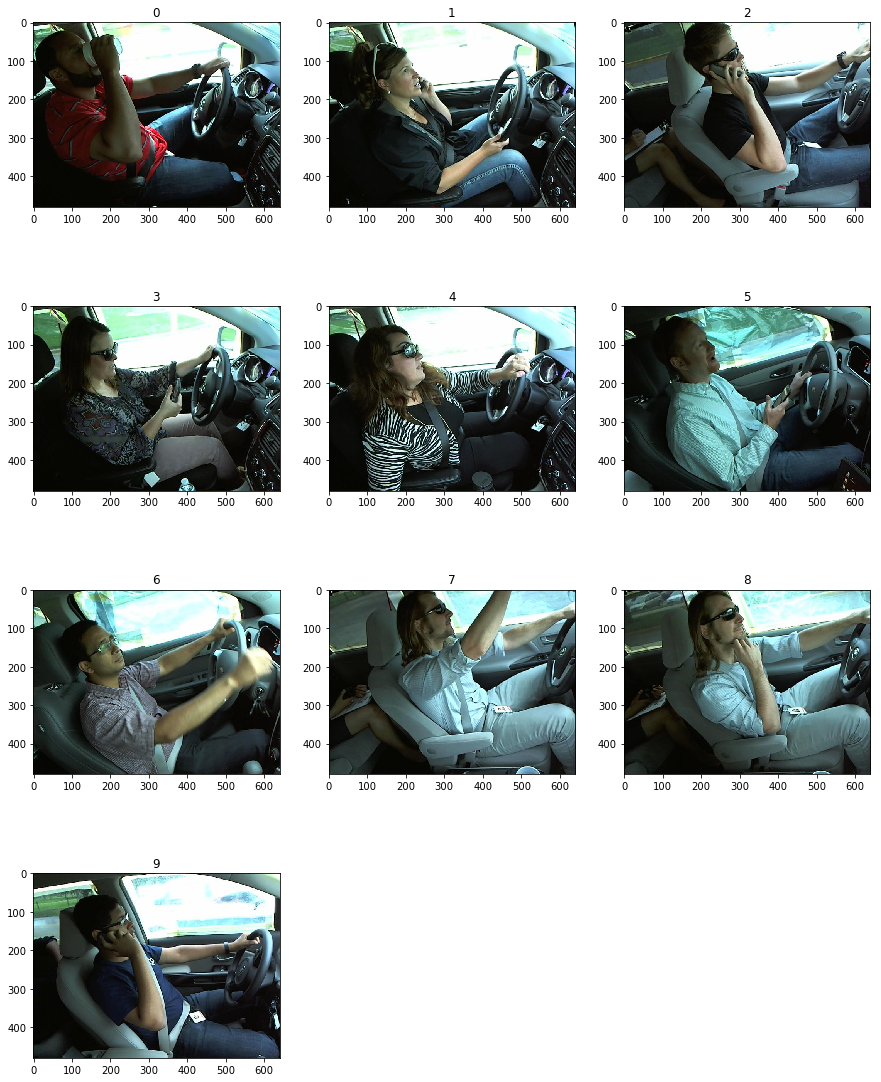

In [84]:
show_image_and_class_multi(range(0, 10), columns=3, subplot_size=(5, 5))

# Submit

In [ ]:
subm_name = path + '/results/subm.csv.gz'

In [ ]:
classes = sorted(batches.class_indices, key=batches.class_indices.get)

In [ ]:
submission = pd.DataFrame(pred, columns=classes)
submission.insert(0, 'img', [a[8:] for a in test_batches.filenames])

In [ ]:
submission.to_csv(subm_name, index=False, compression='gzip')

In [ ]:
submission.head()